# Analysis of Respiratory Data during Tonic-clonic Seizures

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import resample
import seaborn as sns

from preepiseizures.src import Patient, biosignal_processing
import Respiration_2023 as resp

In [3]:
# choose patient


patient = 'WOSQ'

# get metadata
patient_info = Patient.patient_class(patient)
patient_info.get_seizure_annotations()
patient_info.seizure_table

Seizure label file not found for patient WOSQ
No seizure annotations found for patient WOSQ


""


In [4]:
# get data
data_path = f'data{os.sep}respiration{os.sep}{patient}_all_respiration_data.parquet'

data = pd.read_parquet(data_path)
data = Patient.correct_patient(data, patient)
data.head(5)

,RESP,ECG,datetime
0,1.699855,319.205966,2019-02-26 11:10:35.275000000
1,3.442863,325.494349,2019-02-26 11:10:35.287501711
2,3.030720,322.136344,2019-02-26 11:10:35.300003423
3,3.305055,323.705027,2019-02-26 11:10:35.312505134
4,3.142359,322.995388,2019-02-26 11:10:35.325006846


## Autoencoder for Respiration - Epilepsy

1) Filter Respiratory Signals
2) Segment into 1 minute segments (with overlap)
3) Normalize segments between 0 and 1

4) Give to the model trained in the RGBT data

In [5]:
corr_points = pd.read_parquet(f'data{os.sep}respiration{os.sep}{patient}_respiration_corr_points_all.parquet')
time_corr_points = [pd.date_range(corr_points.index[i], corr_points.index[i]+pd.Timedelta(seconds=60), periods=10) for i in range(len(corr_points.index))]
corr_points = pd.DataFrame(np.hstack(corr_points.values), index=np.hstack(time_corr_points))
corr_points = Patient.correct_patient(corr_points, patient)

In [6]:
data_part = data.loc[data['datetime'].between(corr_points.index[0], corr_points.index[-1])].copy()
data_part.head(5)

,RESP,ECG,datetime
0,1.699855,319.205966,2019-02-26 11:10:35.275000000
1,3.442863,325.494349,2019-02-26 11:10:35.287501711
2,3.030720,322.136344,2019-02-26 11:10:35.300003423
3,3.305055,323.705027,2019-02-26 11:10:35.312505134
4,3.142359,322.995388,2019-02-26 11:10:35.325006846


In [7]:
data_part['datetime'].dt.round('1S')

0          2019-02-26 11:10:35
1          2019-02-26 11:10:35
2          2019-02-26 11:10:35
3          2019-02-26 11:10:35
4          2019-02-26 11:10:35
                   ...        
12378538   2019-03-01 15:35:35
12378539   2019-03-01 15:35:35
12378540   2019-03-01 15:35:35
12378541   2019-03-01 15:35:35
12378542   2019-03-01 15:35:35
Name: datetime, Length: 12378543, dtype: datetime64[ns]

## Analysis of Correlation During Seizures

In [8]:
corr_points['datetime'] = corr_points.index

## Respiration Analysis in ECG Quality Intervals

In [9]:
# Remove periods of bad quality
# see in segments of 10 seconds
# if the std is too high, remove the whole segment
# if the std is too low, remove the whole segment
timestamps_ = pd.date_range(data_part['datetime'].iloc[0], data_part['datetime'].iloc[-1], freq='10S')

data_part['datetimeS'] = data_part['datetime'].dt.round('10S')

def quality_check(x):
    
    if (x['ECG'].std() < 50) & (x['ECG'].std() > 5):
        print(x['ECG'].std())

        return x
    else:
        return None

data_quality = data_part.resample(on='datetime', rule='10S').apply(lambda x: quality_check(x))


28.498662795115536
35.03387618225471
31.053000695427702
49.978143105779345
35.31922104635986
28.230068899095972
22.638248527228782
24.355919206097763
22.069015051649604
19.506804911098246
21.25074567500366
20.599556984885968
29.657213622934744
20.217132278853132
29.26707265004604
32.91818006664433
20.230344261973507
21.69078428389942
19.801557128640063
28.952963026885204
45.72373597416452
49.49370530766571
44.83322788209576
42.907512112201616
47.250042550484125
44.2491914455503
40.541551482774814
38.33680236400248
39.20376897858577
39.15620218845865
42.16494613865136
43.05676506320691
44.62610489172212
44.95929341666073
49.41535149664344
41.42041904054381
45.12853103306708
44.81048465533823
44.987901767411124
47.624088105052195
46.241275810983254
45.55218697413088
44.86951595051697
41.34274659528413
42.34076858486774
41.409810331793835
42.844731285583855
40.24390559384646
42.50103034877611
40.23081835950101
41.76974109306358
48.84136527144483
46.65936244546205
46.09775111758428
42.2211

<Axes: >

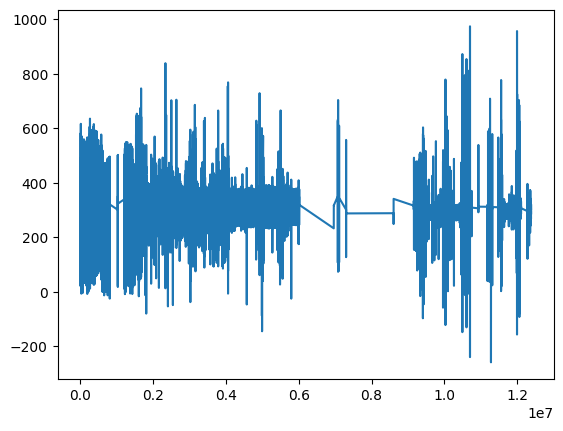

In [10]:
data_quality['ECG'].plot()

In [11]:
data_quality['datetime'] = data_part.loc[data_part.index.isin(data_quality.index)]['datetime']

In [12]:
time_jumps = np.where(data_part['datetime'].diff().dt.total_seconds().values > 0.02)[0]
time_jumps

array([    6720,    17113,   305073,   419609,   422601,   710561,
        1364849,  1652809,  1940825,  1949225,  2063137,  2064737,
        2071825,  2073465,  2088497,  2163465,  2172017,  2175401,
        2207065,  2278705,  2312193,  2314129,  2320873,  2333785,
        2335921,  2340537,  2349025,  2355281,  2362457,  2364721,
        2368697,  2373081,  2396257,  2404705,  2692665,  2941193,
        2972753,  2976857,  3264817,  3327177,  3329809,  3617769,
        3734897,  4022849,  4886897,  5174913,  5750945,  6012033,
        6014041,  6028369,  6316329,  6796121,  6815177,  6975617,
        7084473,  7172633,  7188593,  7223265,  7228633,  7244241,
        7247913,  7257129,  7266025,  7300633,  7358201,  7366305,
        7425289,  7520921,  7622193,  7660065,  7725761,  7743449,
        7746737,  7749801,  7801065,  8089025,  8123865,  8152025,
        8171305,  8185073,  8199225,  8207601,  8266617,  8380801,
        8553369,  8604489,  8830921,  8880769,  9137145,  9146

In [13]:
resp_rate, resp_times = [], []

time_jumps = np.where(data_part['datetime'].diff().dt.total_seconds().values > 0.02)[0]
time_jumps = np.hstack((0, time_jumps, len(data_part)))

for i in range(len(time_jumps)-1):
    resp_rate_, resp_times_ = biosignal_processing.resp_rate(data_part.iloc[time_jumps[i]:time_jumps[i+1]]['RESP'].values, 80)
    resp_rate.append(resp_rate_)
    resp_times.append(resp_times_ + time_jumps[i])
resp_rate = np.hstack(resp_rate)
resp_times = np.hstack(resp_times)

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


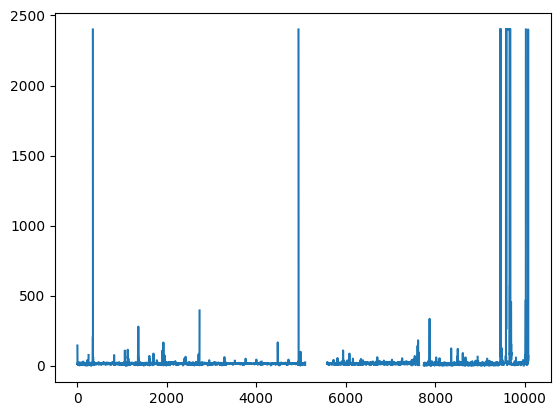

In [14]:
plt.plot(resp_rate)

In [15]:
resp_timestamps = data_part.iloc[resp_times]['datetime']

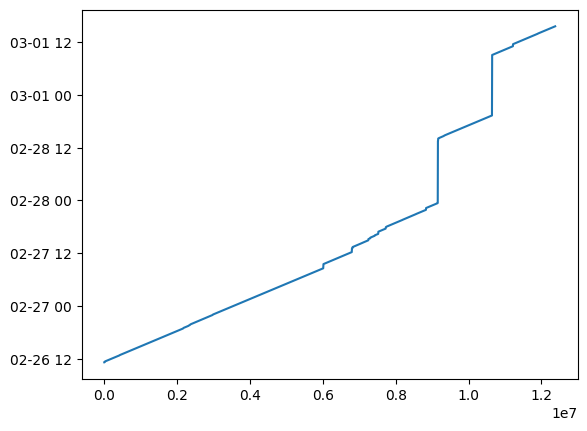

In [16]:
plt.plot(resp_timestamps)

In [17]:
# compare correlation points with respiration rate

resp_df = pd.DataFrame(resp_rate, index=resp_timestamps, columns=['resp_rate'])
resp_df['datetime'] = resp_df.index
resp_df

,resp_rate,datetime
datetime,,
2019-02-26 11:11:05.279107754,144.564706,2019-02-26 11:11:05.279107754
2019-02-26 11:11:20.281161631,14.939973,2019-02-26 11:11:20.281161631
2019-02-26 11:11:35.283215508,19.695193,2019-02-26 11:11:35.283215508
2019-02-26 11:11:50.285269385,14.062500,2019-02-26 11:11:50.285269385
2019-02-26 11:12:47.176080831,10.968921,2019-02-26 11:12:47.176080831
...,...,...
2019-03-01 15:34:30.605619348,NaN,2019-03-01 15:34:30.605619348
2019-03-01 15:34:45.605775515,NaN,2019-03-01 15:34:45.605775515
2019-03-01 15:35:00.605931682,NaN,2019-03-01 15:35:00.605931682


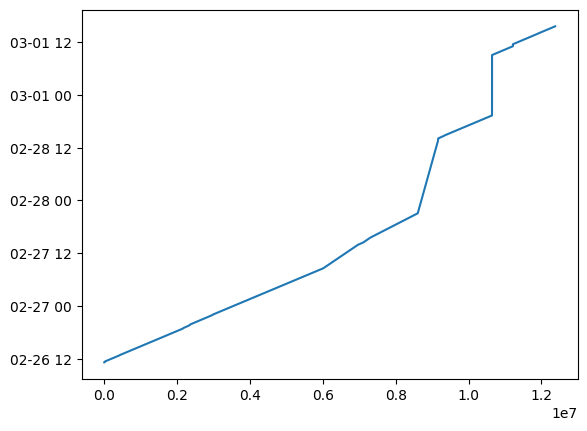

In [18]:
plt.plot(data_quality['datetime'])
plt.show()

In [19]:
data_quality_times = data_quality['datetime'].dt.round('1S').unique()
data_quality_times

<DatetimeArray>
['2019-02-26 11:10:35', '2019-02-26 11:10:36', '2019-02-26 11:10:37',
 '2019-02-26 11:10:38', '2019-02-26 11:10:39', '2019-02-26 11:10:40',
 '2019-02-26 11:10:41', '2019-02-26 11:10:42', '2019-02-26 11:10:43',
 '2019-02-26 11:10:44',
 ...
 '2019-03-01 15:35:11', '2019-03-01 15:35:12', '2019-03-01 15:35:13',
 '2019-03-01 15:35:14', '2019-03-01 15:35:15', '2019-03-01 15:35:16',
 '2019-03-01 15:35:17', '2019-03-01 15:35:18', '2019-03-01 15:35:19',
 '2019-03-01 15:35:20']
Length: 91117, dtype: datetime64[ns]

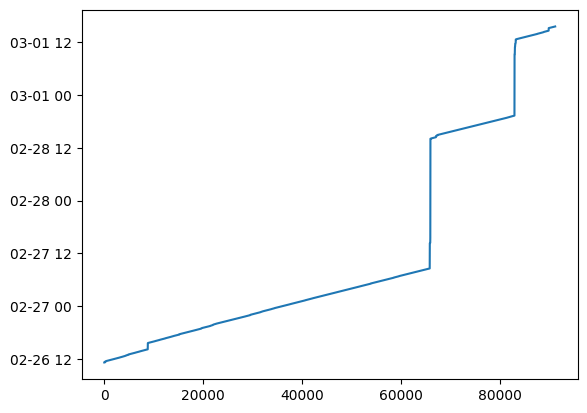

In [20]:
plt.plot(data_quality_times)
plt.show()

In [21]:
corr_points

,0,datetime
2019-02-26 11:10:35.275000000,-0.033483,2019-02-26 11:10:35.275000000
2019-02-26 11:10:41.941666666,0.256007,2019-02-26 11:10:41.941666666
2019-02-26 11:10:48.608333333,0.884917,2019-02-26 11:10:48.608333333
2019-02-26 11:10:55.275000000,0.403817,2019-02-26 11:10:55.275000000
2019-02-26 11:11:01.941666666,-0.028094,2019-02-26 11:11:01.941666666
...,...,...
2019-03-01 15:35:08.614001353,0.258524,2019-03-01 15:35:08.614001353
2019-03-01 15:35:15.280668020,-0.108797,2019-03-01 15:35:15.280668020
2019-03-01 15:35:21.947334686,0.618034,2019-03-01 15:35:21.947334686
2019-03-01 15:35:28.614001353,0.294722,2019-03-01 15:35:28.614001353


In [22]:
corr_points_1s = corr_points.resample('1S').mean()

In [23]:
# only at quality points

resp_rate_1s = resp_df.resample('1S', on='datetime').mean()

In [24]:
data_quality_corr = corr_points_1s.loc[corr_points_1s.index.isin(data_quality_times)].copy()
data_quality_corr['datetime'] = data_quality_corr.index

In [25]:
data_quality_rate = resp_rate_1s.loc[resp_rate_1s.index.isin(data_quality_times)].copy()
data_quality_rate.ffill(inplace=True)
data_quality_rate

,resp_rate
datetime,
2019-02-26 11:11:05,144.564706
2019-02-26 11:11:06,144.564706
2019-02-26 11:11:07,144.564706
2019-02-26 11:11:08,144.564706
2019-02-26 11:11:09,144.564706
...,...
2019-03-01 15:35:16,68.965517
2019-03-01 15:35:17,68.965517
2019-03-01 15:35:18,68.965517


In [26]:
data_quality_corr = data_quality_corr.merge(data_quality_rate, on='datetime')

In [27]:
data_quality_corr.dropna(inplace=True)

In [28]:
data_quality_corr

,0,datetime,resp_rate
3,-0.120278,2019-02-26 11:11:08,144.564706
10,0.703489,2019-02-26 11:11:15,144.564706
16,-0.422426,2019-02-26 11:11:21,14.939973
23,0.403615,2019-02-26 11:11:28,14.939973
30,0.094973,2019-02-26 11:11:35,19.695193
...,...,...,...
91054,0.350669,2019-03-01 15:34:48,68.965517
91061,-0.518845,2019-03-01 15:34:55,68.965517
91067,0.061270,2019-03-01 15:35:01,68.965517
91074,0.258524,2019-03-01 15:35:08,68.965517


In [29]:
fig = px.scatter(data_quality_corr, x=0, y='resp_rate', title=f'{patient} respiration')
fig.show()

In [30]:
#fig = px.line(data_part.iloc[-1500000:-950000], x='datetime', y=['ECG', 'RESP'])
#fig.show()

In [31]:
fig = px.line(data_quality_corr, y='resp_rate',title=f'{patient} respiration')
#for i in range(len(patient_info.seizure_table)):
#    fig.add_vline(patient_info.seizure_table.iloc[i]['Timestamp'], line_width=3, line_dash='dash', line_color='red')
fig.show()

In [32]:
# histogram in bins of respiration rate bpm

# first bin 0-8 BPM
bpm_08 = data_quality_corr.loc[data_quality_corr['resp_rate'] < 10].copy()
# second bin 8-10 BPM
bpm_10 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 10) & (data_quality_corr['resp_rate'] >= 8)].copy()
# third bin 10-12 BPM
bpm_12 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 12) & (data_quality_corr['resp_rate'] >= 8)].copy()
# fourth bin 12-14 BPM
bpm_14 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 14) & (data_quality_corr['resp_rate'] >= 12)].copy()
# fifth bin 14-16 BPM
bpm_16 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 16) & (data_quality_corr['resp_rate'] >= 12)].copy()
# sixth bin 16-18 BPM
bpm_18 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 18) & (data_quality_corr['resp_rate'] >= 16)].copy()
# seventh bin 18-20 BPM
bpm_20 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 20) & (data_quality_corr['resp_rate'] >= 16)].copy()
# eighth bin 20-22 BPM
bpm_22 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 22) & (data_quality_corr['resp_rate'] >= 20)].copy()
# ninth bin 22-24 BPM
bpm_24 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 24) & (data_quality_corr['resp_rate'] >= 20)].copy()
# tenth bin 24-150 BPM
bpm_150 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 150) & (data_quality_corr['resp_rate'] >= 24)].copy()

In [42]:
dict_bpm = {0:[0, 4, '0-4'], 1:[4, 8, '4-8'], 2:[8, 12, '8-12'], 
         3:[12, 16, '12-16'], 4:[16, 20, '16-20'], 5:[20, 24, '20-24'], 
         6:[24, 28, '24-28'], 7:[28, 2500, '28+']}

data_quality_corr['bpm'] = ''
for i in range(8):
    data_quality_corr.loc[(data_quality_corr['resp_rate'] < dict_bpm[i][1]) & (data_quality_corr['resp_rate'] >= dict_bpm[i][0]), 'bpm'] = dict_bpm[i][2]
data_quality_corr
data_quality_corr.rename(columns={0:'IO Correlation'}, inplace=True)
data_quality_corr.sort_values(by='resp_rate', inplace=True)

In [45]:
len(data_quality_corr.loc[data_quality_corr['bpm'] == '28+'])

526

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight

/Users/saraiva/dev

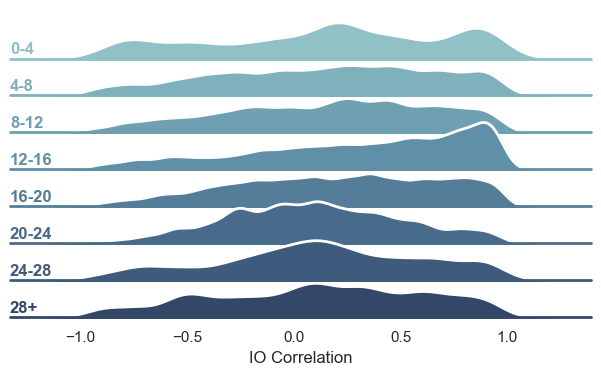

In [46]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(data_quality_corr, row="bpm", hue="bpm", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'IO Correlation',
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'IO Correlation', clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'IO Correlation')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.savefig(f'data{os.sep}figures{os.sep}{patient}_respiration_correlation.png', dpi=300)


In [64]:
from scipy.stats import mannwhitneyu



mannwhitneyu(
        data_quality_corr.groupby('bpm').get_group('8-12')['IO Correlation'].values,
        
        data_quality_corr.groupby('bpm').get_group('12-16')['IO Correlation'].values)
        

MannwhitneyuResult(statistic=2668032.0, pvalue=1.5069173966477251e-24)